<a href="https://colab.research.google.com/github/MeghanaR123/Video_dehazing_project/blob/main/video_dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch import nn

# Define the FFA model (Directly included here)
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size // 2), bias=bias)

class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.pa(x)
        return x * y

class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res + x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res += x
        return res

class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size) for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res += x
        return res

class FFA(nn.Module):
    def __init__(self, gps, blocks, conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps == 3
        self.g1 = Group(conv, self.dim, kernel_size, blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size, blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size, blocks=blocks)
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim * self.gps, self.dim // 16, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim // 16, self.dim * self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.palayer = PALayer(self.dim)
        post_process = [conv(self.dim, self.dim, kernel_size), conv(self.dim, 3, kernel_size)]
        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)
        w = self.ca(torch.cat([res1, res2, res3], dim=1))
        w = w.view(-1, self.gps, self.dim)[:, :, :, None, None]
        out = w[:, 0, :] * res1 + w[:, 1, :] * res2 + w[:, 2, :] * res3
        out = self.palayer(out)
        x = self.post(out)
        return x + x1

# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gps = 3
blocks = 19

# Load pre-trained model
pretrained_model_dir = '/content/drive/MyDrive/synthetic-objective-testing-set-sots-reside/ffanet-pretrained-weights/' + f'ots_train_ffa_{gps}_{blocks}.pk'  # Update with your model path
net = FFA(gps=gps, blocks=blocks)
net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(pretrained_model_dir, map_location=device)['model'])
net.to(device)
net.eval()

print("Model loaded successfully!")

<ipython-input-2-0e7d869c8809>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(pretrained_model_dir, map_location=device)['model'])


Model loaded successfully!


In [ ]:
# !mkdir /content/drive/MyDrive/input_videos
# !rm -rf /content/drive/MyDrive/dehazed_frames_folder/fog
# !rm -rf /content/drive/MyDrive/AHE/wood

In [ ]:
import cv2

def reduce_video_resolution(input_path, output_path):
    # Open the input video
    cap = cv2.VideoCapture(input_path)

    # Get original width and height of the video
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate half resolution
    new_width = original_width // 2
    new_height = original_height // 2

    # Get the frame rate of the original video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Set up output video writer with half resolution and original fps
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to half of original width and height
        resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

        # Write the resized frame to the output video
        out.write(resized_frame)

    # Release resources
    cap.release()
    out.release()
    print("Video saved with half resolution at:", output_path)

# Usage example
input_video = '/content/sample_data/wood.mp4'      # Path to original video
output_video = '/content/drive/MyDrive/input_videos/wood.mp4'  # Path to save resized video
reduce_video_resolution(input_video, output_video)

Video saved with half resolution at: /content/drive/MyDrive/input_videos/wood.mp4


In [ ]:
# import cv2
# import os
# from tqdm import tqdm

# # Path to the input video file
# video_path = '/content/drive/MyDrive/input_videos/wood.mp4'

# # Folder to save extracted frames
# output_folder = '/content/drive/MyDrive/frames_folder/wood'
# os.makedirs(output_folder, exist_ok=True)

# # Load the video
# video_capture = cv2.VideoCapture(video_path)

# # Frame extraction loop
# frame_number = 0
# total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

# for i in tqdm(range(total_frames), desc="Extracting Frames"):
#     success, frame = video_capture.read()
#     if not success:
#         break

#     # Save frame as image
#     frame_filename = os.path.join(output_folder, f"frame_{frame_number:04d}.png")
#     cv2.imwrite(frame_filename, frame)

#     frame_number += 1

# video_capture.release()
# print(f"Extraction complete. Frames saved to: {output_folder}")


In [ ]:
import cv2
import os
from tqdm import tqdm

def extract_frames(video_path, output_folder, frame_limit=60):
    # Ensure the output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Load the video
    video_capture = cv2.VideoCapture(video_path)

    # Get the total frame count
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames = min(total_frames, frame_limit)  # Limit to the frame_limit

    # Frame extraction loop
    frame_number = 0
    for i in tqdm(range(total_frames), desc="Extracting Frames"):
        success, frame = video_capture.read()
        if not success or frame_number >= frame_limit:
            break

        # Save each frame as an image
        frame_filename = os.path.join(output_folder, f"frame_{frame_number:04d}.png")
        cv2.imwrite(frame_filename, frame)
        frame_number += 1

    # Release the video capture object
    video_capture.release()
    print(f"Extraction complete. Frames saved to: {output_folder}")

# Example call to the function
extract_frames('/content/drive/MyDrive/input_videos/wood.mp4', '/content/drive/MyDrive/frames_folder/wood', frame_limit=60)

Extracting Frames: 100%|██████████| 60/60 [00:24<00:00,  2.48it/s]

Extraction complete. Frames saved to: /content/drive/MyDrive/frames_folder/wood


In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms as tfs
from tqdm import tqdm

# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set model parameters
gps = 3
blocks = 19

# Load pretrained model (update with your model path)
pretrained_model_dir =  '/content/drive/MyDrive/synthetic-objective-testing-set-sots-reside/ffanet-pretrained-weights/' + f'ots_train_ffa_{gps}_{blocks}.pk'

# Define FFA model (assuming the FFA class is already defined)
net = FFA(gps=gps, blocks=blocks)
net = nn.DataParallel(net)
net.load_state_dict(torch.load(pretrained_model_dir, map_location=device)['model'])
net.to(device)
net.eval()

# Folder paths
input_frames_dir = '/content/drive/MyDrive/frames_folder/wood'  # Your input frames folder
output_frames_dir = '/content/drive/MyDrive/dehazed_frames_folder/wood'  # Output folder for dehazed frames
os.makedirs(output_frames_dir, exist_ok=True)

# Set frame limit (e.g., process only the first 100 frames)
frame_limit = 60

# Process each frame up to the limit
frame_count = 0
for frame_file in tqdm(sorted(os.listdir(input_frames_dir)), desc="Dehazing Frames"):
    if frame_count >= frame_limit:
        break

    frame_path = os.path.join(input_frames_dir, frame_file)
    hazy_image = Image.open(frame_path)

    # Preprocess the frame
    transform = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.64, 0.6, 0.58], std=[0.14, 0.15, 0.152])
    ])
    hazy_tensor = transform(hazy_image).unsqueeze(0).to(device)

    # Dehaze the frame
    with torch.no_grad():
        dehazed_tensor = net(hazy_tensor)

    # Convert tensor to image and save
    output_image = dehazed_tensor.squeeze(0).cpu().clamp(0, 1)

    output_image = tfs.ToPILImage()(output_image)
    output_image.save(os.path.join(output_frames_dir, frame_file))

    frame_count += 1

print(f"Dehazing complete. Frames saved to: {output_frames_dir}")

<ipython-input-7-b7d499c4669c>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(pretrained_model_dir, map_location=device)['model'])
Dehazing

Dehazing complete. Frames saved to: /content/drive/MyDrive/dehazed_frames_folder/wood


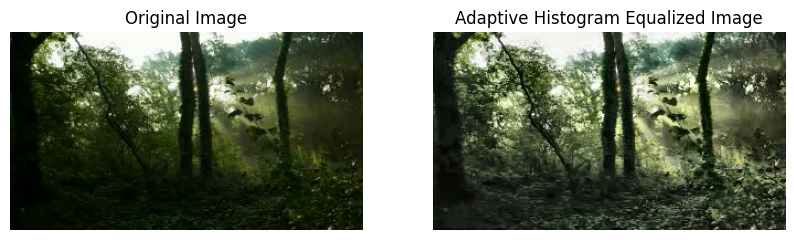

array([[[ 32,  51,  31],
        [ 33,  57,  34],
        [ 16,  22,  14],
        ...,
        [ 22,  40,  33],
        [  0,  21,   7],
        [  6,  29,  18]],

       [[ 43,  62,  48],
        [ 33,  48,  42],
        [  5,   7,   8],
        ...,
        [ 18,  31,  20],
        [  3,  21,  19],
        [ 16,  31,  21]],

       [[ 40,  66,  53],
        [ 39,  57,  49],
        [ 20,  27,  22],
        ...,
        [ 18,  30,  23],
        [ 10,  25,  18],
        [ 10,  17,   7]],

       ...,

       [[  6,   6,   6],
        [ 20,  25,  18],
        [ 20,  25,  18],
        ...,
        [ 33,  50,  36],
        [ 57,  89,  69],
        [ 45,  74,  57]],

       [[  6,   6,   6],
        [ 11,  11,  11],
        [  9,  11,  13],
        ...,
        [ 19,  30,  27],
        [ 47,  74,  56],
        [ 34,  54,  41]],

       [[  6,   6,   6],
        [ 16,   9,  18],
        [  9,  13,   7],
        ...,
        [ 23,  38,  27],
        [ 69, 103,  84],
        [ 27,  45,  25]]], dtype=uint8)
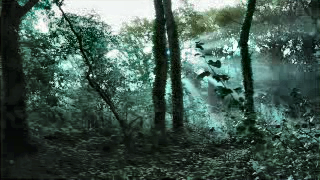

In [ ]:
# @title Default title text
import cv2
import matplotlib.pyplot as plt

def adaptive_histogram_equalization_color(image_path, clip_limit=3.0, tile_grid_size=(8, 8)):
    # Read the image in color (BGR format)
    img = cv2.imread(image_path)

    # Convert the image from BGR to LAB color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Split the LAB image to L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_img)

    # Apply CLAHE to the L channel (luminosity channel)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel with A and B channels
    lab_img = cv2.merge((cl, a_channel, b_channel))

    # Convert the LAB image back to BGR color space
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

    # Display the original and equalized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Adaptive Histogram Equalized Image")
    plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
    return enhanced_img

# Example usage
image_path = '/content/drive/MyDrive/dehazed_frames_folder/wood/frame_0004.png'  # Path to the input color image
adaptive_histogram_equalization_color(image_path)

In [ ]:
import cv2
import os
import glob
from tqdm import tqdm  # Import tqdm for the progress bar

def apply_ahe_to_folder(input_folder, output_folder, clip_limit=4.0, tile_grid_size=(8, 8)):
    # Get a list of all images in the input folder
    image_files = glob.glob(os.path.join(input_folder, "*.*"))

    # Process each image with tqdm progress bar
    for image_path in tqdm(image_files, desc="Processing images"):
        # Read the image
        img = cv2.imread(image_path)

        if img is None:
            print(f"Could not read image {image_path}. Skipping.")
            continue

        # Convert the image to LAB color space
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Split the LAB image to L, A, and B channels
        l_channel, a_channel, b_channel = cv2.split(lab_img)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(l_channel)

        # Merge the CLAHE enhanced L channel with A and B channels
        lab_img = cv2.merge((cl, a_channel, b_channel))

        # Convert the LAB image back to BGR color space
        enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

        # Define the output path
        output_path = os.path.join(output_folder, os.path.basename(image_path))

        # Save the enhanced image to the output folder
        cv2.imwrite(output_path, enhanced_img)

# Set input and output folder paths
input_folder = "/content/drive/MyDrive/dehazed_frames_folder/wood"
output_folder = "/content/drive/MyDrive/AHE/wood"

# Apply AHE to all images in the input folder and save to output folder
apply_ahe_to_folder(input_folder, output_folder)

Processing images: 100%|██████████| 60/60 [00:27<00:00,  2.17it/s]


In [ ]:
# import cv2
# import os
# from tqdm import tqdm

# # Folder with dehazed frames
# dehazed_frames_dir = '/content/drive/MyDrive/AHE/wood'
# output_video_path = '/content/drive/MyDrive/wood_dehazed_video.mp4'  # Output video path

# # Set frame limit (same as the one in dehazing step)
# frame_limit = 200

# # Get the frames
# frame_files = sorted(os.listdir(dehazed_frames_dir))[:frame_limit]  # Limit the number of frames
# frame_path = os.path.join(dehazed_frames_dir, frame_files[0])

# # Read the first frame to get the frame size
# frame = cv2.imread(frame_path)
# height, width, layers = frame.shape

# # Define video codec and create VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video_writer = cv2.VideoWriter(output_video_path, fourcc, 30, (width, height))

# # Write frames to video
# for frame_file in tqdm(frame_files, desc="Creating Video"):
#     frame_path = os.path.join(dehazed_frames_dir, frame_file)
#     frame = cv2.imread(frame_path)
#     video_writer.write(frame)

# video_writer.release()
# print(f"Video creation complete. Dehazed video saved to: {output_video_path}")

In [ ]:
import cv2
import os
from tqdm import tqdm

def create_video_from_frames(dehazed_frames_dir, output_video_path, frame_limit=60, frame_rate=30):

    # Get the frames, limited by frame_limit
    frame_files = sorted(os.listdir(dehazed_frames_dir))[:frame_limit]

    # Ensure there are frames to process
    if not frame_files:
        print("No frames found in the specified directory.")
        return

    # Read the first frame to get the frame size
    first_frame_path = os.path.join(dehazed_frames_dir, frame_files[0])
    frame = cv2.imread(first_frame_path)
    height, width, layers = frame.shape

    # Define video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

    # Write frames to the video
    for frame_file in tqdm(frame_files, desc="Creating Video"):
        frame_path = os.path.join(dehazed_frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        video_writer.write(frame)

    # Release the VideoWriter
    video_writer.release()
    print(f"Video creation complete. Dehazed video saved to: {output_video_path}")

# Example usage
create_video_from_frames('/content/drive/MyDrive/AHE/wood', '/content/drive/MyDrive/code/static/wood_dehazed_video.mp4', frame_limit=60, frame_rate=30)

Creating Video: 100%|██████████| 60/60 [00:00<00:00, 95.20it/s]

Video creation complete. Dehazed video saved to: /content/drive/MyDrive/code/static/wood_dehazed_video.mp4


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as tfs
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as FF
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchvision.models import vgg16

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size//2), bias=bias)


class PALayer(nn.Module):
    def __init__(self, channel):
        super(PALayer, self).__init__()
        self.pa = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, 1, 1, padding=0, bias=True),
                nn.Sigmoid()
        )
    def forward(self, x):
        y = self.pa(x)
        return x * y


class CALayer(nn.Module):
    def __init__(self, channel):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
                nn.Conv2d(channel, channel // 8, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 8, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y


class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size,):
        super(Block, self).__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)

    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res+x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res += x
        return res


class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super(Group, self).__init__()
        modules = [Block(conv, dim, kernel_size)  for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)

    def forward(self, x):
        res = self.gp(x)
        res += x
        return res


class FFA(nn.Module):
    def __init__(self,gps,blocks,conv=default_conv):
        super(FFA, self).__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [conv(3, self.dim, kernel_size)]
        assert self.gps==3
        self.g1 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g2 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.g3 = Group(conv, self.dim, kernel_size,blocks=blocks)
        self.ca = nn.Sequential(*[
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim*self.gps,self.dim//16,1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim//16, self.dim*self.gps, 1, padding=0, bias=True),
            nn.Sigmoid()
            ])
        self.palayer = PALayer(self.dim)

        post_process = [
            conv(self.dim, self.dim, kernel_size),
            conv(self.dim, 3, kernel_size)]

        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)
        w = self.ca(torch.cat([res1,res2,res3],dim=1))
        w = w.view(-1,self.gps, self.dim)[:,:,:,None,None]
        out = w[:,0,::] * res1 + w[:,1,::] * res2+w[:,2,::] * res3
        out = self.palayer(out)
        x = self.post(out)
        return x + x1

In [ ]:
# @title Default title text
ngrok_key = "2nuy6IfdYBXv4eC5RrTsoAK6HWy_7ahCRz4y8Vchj3Ntz4nR6"
port = 5000

In [ ]:
# @title Default title text
!pip install Flask==3.0.0 pyngrok==7.1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
# @title Default title text
from pyngrok import ngrok
ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://d1a4-34-19-100-244.ngrok-free.app'

In [ ]:
# @title Default title text
# from flask import Flask, request, render_template, url_for
# import os
# import torch
# import torch.nn as nn
# from torchvision.utils import save_image
# import torchvision.transforms as tfs
# import cv2
# from moviepy.editor import VideoFileClip

# app = Flask(__name__, template_folder='/content/drive/MyDrive/code/templates',
#                       static_folder='/content/drive/MyDrive/code/static')

# # Device setup
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# gps = 3
# blocks = 19

# # Load pre-trained model
# pretrained_model_dir = '/content/drive/MyDrive/synthetic-objective-testing-set-sots-reside/ffanet-pretrained-weights/' + f'ots_train_ffa_{gps}_{blocks}.pk'
# ckp = torch.load(pretrained_model_dir, map_location=device)
# net = FFA(gps=gps, blocks=blocks)
# net = nn.DataParallel(net)
# net.load_state_dict(ckp['model'])
# net.to(device)
# net.eval()

# @app.route('/')
# def main():
#     return render_template("/content/drive/MyDrive/code/templates/vindex.html")

# @app.route('/success', methods=['POST'])
# # def success():
# #     if request.method == 'POST':
# #         f = request.files['file']
# #         upload_folder = os.path.join(app.static_folder, '')
# #         if not os.path.exists(upload_folder):
# #             os.makedirs(upload_folder)

# #         # Save uploaded video file
# #         fname = os.path.join(upload_folder, f.filename)
# #         f.save(fname)

#         # # Process video for dehazing frame by frame
#         # video_input_path = fname
#         # video_output_path = os.path.join(upload_folder, 'output_video.mp4')

#         # # Open input video
#         # cap = cv2.VideoCapture(video_input_path)
#         # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#         # out = cv2.VideoWriter(video_output_path, fourcc, 30.0, (640, 480))  # Adjust resolution and FPS

#         # while cap.isOpened():
#         #     ret, frame = cap.read()
#         #     if not ret:
#         #         break

#         #     # Convert frame to tensor and normalize
#         #     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         #     frame_tensor = tfs.Compose([
#         #         tfs.ToTensor(),
#         #         tfs.Normalize(mean=[0.64, 0.6, 0.58], std=[0.14, 0.15, 0.152])
#         #     ])(frame_rgb)[None, ::].to(device)

#         #     with torch.no_grad():
#         #         pred = net(frame_tensor)

#         #     # Convert output tensor back to image
#         #     pred_image = pred.squeeze().cpu().numpy().transpose(1, 2, 0) * 255
#         #     pred_image = cv2.cvtColor(pred_image.astype('uint8'), cv2.COLOR_RGB2BGR)

#         #     # Write the dehazed frame to the output video
#         #     out.write(pred_image)

#         # # Release resources
#         # cap.release()
#         # out.release()

#         # Display results in HTML
#         # return render_template("/content/drive/MyDrive/code/templates/vindex.html", input_video=f.filename, output_video='output_video.mp4')
# def success():
#     if request.method == 'POST':
#         f = request.files['file']
#         # Define the upload folder and ensure it exists
#         upload_folder = os.path.join(app.static_folder, '')
#         if not os.path.exists(upload_folder):
#             os.makedirs(upload_folder)
#         # Save the uploaded file
#         fname = os.path.join(upload_folder, f.filename)
#         f.save(fname)
#         return render_template("vindex.html", input_video=f.filename)
# if __name__ == '__main__':
#     app.run()